### CITS5508 labsheet 5

**Author: Alastair Mory (21120848)**<br>
**Date: May 2020**

In [2]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import pickle

# import other packages needed for the project below this line
import random
# import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras as keras

# Loading Dataset

In [3]:
# IMPOTRTANT: set the path where the data files are relative to the Notebook file. 
# You can change the variable pathname below to anything that suits you, For example,
# if your Notebook file is to be run on Google Colab, then you will need to set up
# this variable properly, e.g., 
#       pathname = os.path.join('My Drive', 'CITS5508').
#
# Before submitting your Notebook file to cssubmit, ensure that you change
# this variable back to '.'
pathname = '.'

RUNNING_IN_COLAB = False
if RUNNING_IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/lab5')
print(os.getcwd())
print(os.listdir('./'))

/home/alastair/Documents/CITS5508/ml-labs/lab5
['lab05.ipynb', '.ipynb_checkpoints']


In [6]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):
    '''
    This function reads the given pickle file and returns a dictionary object.
    '''
    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.', height=32, width=32, Nchannels=3):
    '''
    This function reads the 5 data batches and returns the X_train and y_train numpy arrays.
    To save memory space, X_train is set to 'float32' (single precision floating point numbers).
    If this causes an issue, it can be set to 'float64'. y_train is set to uint8. This is
    the same data type as used in the MNIST dataset, so it should be fine.
    '''
    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(filename_prefix+str(b), path=path) for b in batch_no]

    # variable batches is a list containing 5 elements, each of which is a dictionary object

    # compose our X_train and y_train
    # according to the download site, the training set should have 50,000 instances. We caldulate
    # the length from the dictionary that we read in anyway.
    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)
    
    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.rollaxis(
            np.reshape(batches[i][b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.', height=32, width=32, Nchannels=3):
    '''
    This function reads the test_batch and returns X_test and y_test.
    To save memory space, X_test is set to 'float32' (single precision floating point numbers).
    If this causes an issue, it can be set to 'float64'. y_test is set to uint8. This is
    the same data type as used in the MNIST dataset, so it should be fine.
    '''
    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.rollaxis(np.reshape(test_dict[b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [7]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'

X_train, y_train = load_training(train_filename_prefix, N_batches, path=pathname)
X_test, y_test = load_testing(test_filename, path=pathname)

FileNotFoundError: [Errno 2] No such file or directory: './data_batch_1'

# MLP Network

## Hyperparameters

* connection weight initialisation
* learning rate scheduling
* early stopping

## Architecture

In [29]:
cwi = 'glorot_uniform'  # connection weight initialiser, default 'glorot_uniform'.
es = False  # Whether to perform early stopping or not
lrs = None  # learning rate scheduling: lambda expression or constant, default: 0.01

# Configure MLP Model
mlp_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(256, activation='relu', kernel_initializer=cwi),
    keras.layers.Dense(128, activation='relu', kernel_initializer=cwi),
    keras.layers.Dense(10)
])

# callbacks to perform early stopping or learning rate scheduling.
callbacks = []
if es:
    callbacks.append(keras.callbacks.EarlyStopping('val_loss'))
if lrs:
    scheduler = lambda e, r: lrs
    callbacks.append(keras.callbacks.LearningRateScheduler(scheduler))

mlp_model.compile(optimizer='sgd',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


## Training and Testing

In [30]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=10, callbacks=callbacks, validation_split=0.1)
mlp_model.evaluate(X_test, y_test)
y_pred  = np.array([np.argmax(x) for x in mlp_model.predict(X_test)])


Epoch 1/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.8987 - accuracy: 0.3201 - val_loss: 1.8081 - val_accuracy: 0.3601
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7169 - accuracy: 0.3946 - val_loss: 1.7082 - val_accuracy: 0.3897
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6360 - accuracy: 0.4200 - val_loss: 1.7135 - val_accuracy: 0.3963
Epoch 4/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.5815 - accuracy: 0.4427 - val_loss: 1.5927 - val_accuracy: 0.4393
Epoch 5/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.5365 - accuracy: 0.4570 - val_loss: 1.5569 - val_accuracy: 0.4508
Epoch 6/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.5027 - accuracy: 0.4685 - val_loss: 1.5304 - val_accuracy: 0.4647
Epoch 7/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.4677 - accuracy: 0.4811 - val_loss: 1.5787 - val_accuracy:

## Classification Results

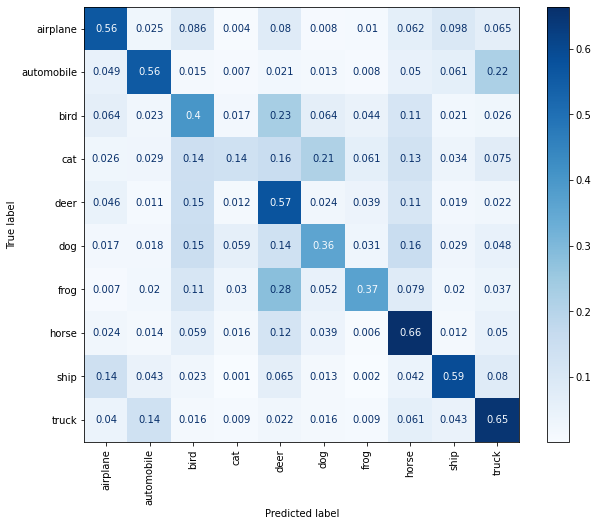

In [10]:
def plot_confusion_matrix(y_true, y_pred,
                          display_labels=class_names,
                          xticks_rotation='vertical',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(1, figsize=(10,8))
    disp.plot(cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

plot_confusion_matrix(y_test, y_pred)

10 randomly selected correctly predicted images


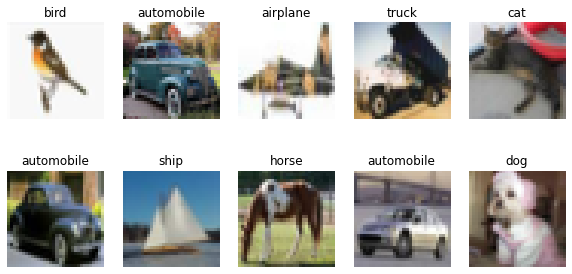

10 randomly selected incorrectly predicted images


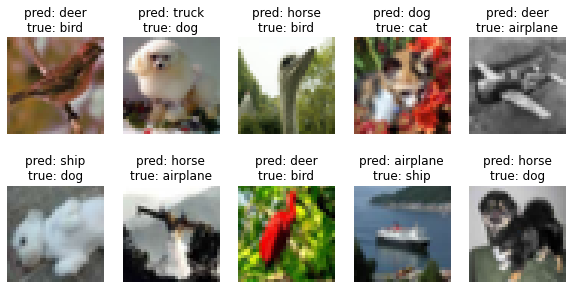

In [0]:
def get_rand_image_pred(x, y_true, y_pred, correct=True):
    i = random.randint(0,len(x)-1)
    if (y_true[i] == y_pred[i]) == correct:
        return (x[i], y_true[i], y_pred[i])
    else:
        return get_rand_image_pred(x, y_true, y_pred, correct)

def plot_sample_images(X_test, y_test, y_pred,
                       correct=True, rows=2, cols=5, figsize=(10,5)):
    correctly = "correctly" if correct else "incorrectly"
    print(f"{rows * cols} randomly selected {correctly} predicted images")
    plt.figure(figsize=figsize)
    for i in range(rows * cols):
        image, tclass, pclass = get_rand_image_pred(X_test, y_test, y_pred, correct)
        ax = plt.subplot(rows,cols,i+1)
        plt.imshow(image)
        plt.axis('off')
        if correct:
            ax.set_title(f"{class_names[pclass]}")
        else:
            ax.set_title(f"pred: {class_names[pclass]}\ntrue: {class_names[tclass]}")
    plt.show()


plot_sample_images(X_test, y_test, y_pred, correct=True)
plot_sample_images(X_test, y_test, y_pred, correct=False)

# CNN


## Hyperparameters

* Kernel size
* Number of kernels (filters)
* Dropout rate
* Activation function


## Architecture

In [4]:
RETRAIN_MODEL = True
checkpoint_filepath = './Mory_Alastair.ckpt'

filters = 32
kernel_size = 2
dropout_rate = 0
activation_function = 'relu'

conv_args = {
    'kernel_size': kernel_size,
    'activation': activation_function,
    'padding': 'same'
}

cnn_model = keras.Sequential([
    keras.layers.Conv2D(filters, **conv_args, input_shape=(32, 32, 3)),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(filters * 2, **conv_args),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=activation_function),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(10, activation='linear')
])

cnn_model.summary()

cnn_model.compile(optimizer='rmsprop',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = []
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True))

if not RETRAIN_MODEL:
    cnn_model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

## Training and Testing

In [5]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, callbacks=callbacks, validation_split=0.2)
y_pred = np.array([np.argmax(x) for x in cnn_model.predict(X_test)])
cnn_model.evaluate(X_test,y_test,verbose=0)


NameError: name 'X_train' is not defined

[1.3945610523223877, 0.6909999847412109]

## Classification Results

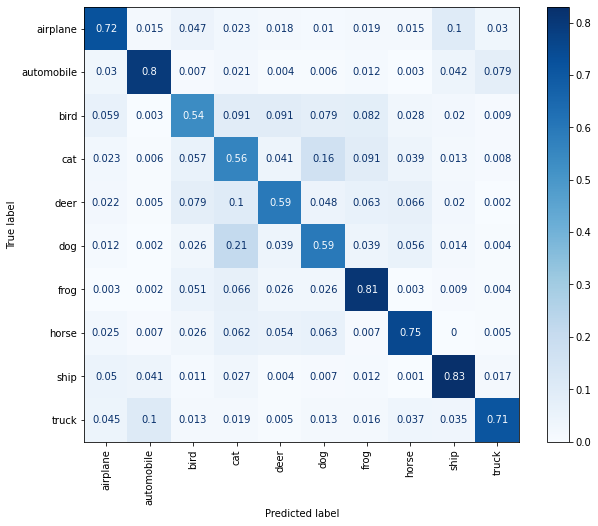

In [15]:
plot_confusion_matrix(y_test, y_pred,)

10 randomly selected correctly predicted images


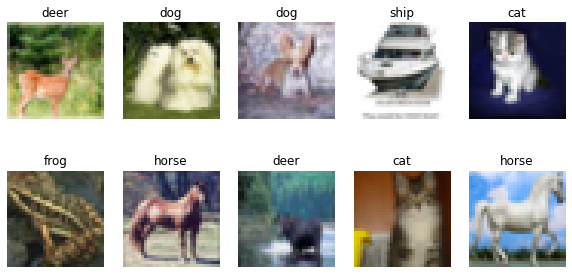

10 randomly selected incorrectly predicted images


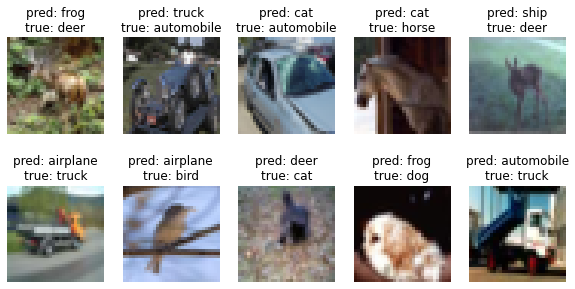

In [16]:
plot_sample_images(X_test, y_test, y_pred, correct=True)
plot_sample_images(X_test, y_test, y_pred, correct=False)

# Comparison


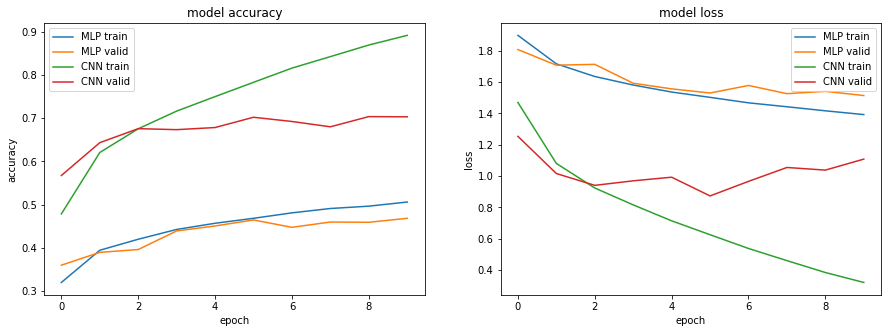

In [45]:
def plot_history():
    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    ax1, ax2 = ax
    
    # summarize history for accuracy  
    
    ax1.plot(mlp_history.history['accuracy'])  
    ax1.plot(mlp_history.history['val_accuracy'])  
    ax1.plot(cnn_history.history['accuracy'])  
    ax1.plot(cnn_history.history['val_accuracy'])  
    ax1.set_title('model accuracy')  
    ax1.set_ylabel('accuracy')  
    ax1.set_xlabel('epoch')  
    ax1.legend(['MLP train', 'MLP valid', 'CNN train', 'CNN valid'], loc='upper left')  
    
    # summarize history for loss  
    ax2.plot(mlp_history.history['loss'])  
    ax2.plot(mlp_history.history['val_loss'])  
    ax2.plot(cnn_history.history['loss'])  
    ax2.plot(cnn_history.history['val_loss'])  
    ax2.set_title('model loss')  
    ax2.set_ylabel('loss')  
    ax2.set_xlabel('epoch')  
    ax2.legend(['MLP train', 'MLP valid', 'CNN train', 'CNN valid'], loc='upper right')  

plot_history()

In [46]:
mlp_model.summary()
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        416       
________________________